In [1]:
#Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import scipy.stats as st
from scipy.stats import linregress
from pprint import pprint

In [2]:
#Create dataframe for Air Quality data from csv files.
aq2020_df = pd.read_csv("Resources/aq2020.csv")
aq2019Q1_df = pd.read_csv("Resources/aq2019Q1.csv")
aq2019Q2_df = pd.read_csv("Resources/aq2019Q2.csv")
aq2019Q3_df = pd.read_csv("Resources/aq2019Q3.csv")

#Create a df to hold all of 2019 data
aq2019_df=pd.concat([aq2019Q1_df,aq2019Q2_df,aq2019Q3_df])

#Format dataframe dates
aq2020_df['Date']= pd.to_datetime(aq2020_df['Date'])
aq2019_df['Date']= pd.to_datetime(aq2019_df['Date'])


In [3]:
#Drop nullvalues and clean AQ data

#drop null values and reset index 2020
clean_aq2020_df = aq2020_df.dropna(how='any')
clean_aq2020_df.reset_index(inplace=True)
del clean_aq2020_df['index']
clean_aq2020_df

#drop null values and reset index 2020
clean_aq2019_df = aq2019_df.dropna(how='any')
clean_aq2019_df.reset_index(inplace=True)
del clean_aq2019_df['index']
clean_aq2019_df



,Date,Country,City,Specie,count,min,max,median,variance
0,2019-01-16,AE,Abu Dhabi,pm10,24.0,86.0,99.0,97.0,179.40
1,2019-01-22,AE,Abu Dhabi,pm10,24.0,51.0,57.0,55.0,23.75
2,2019-01-26,AE,Abu Dhabi,pm10,24.0,136.0,173.0,160.0,941.96
3,2019-01-07,AE,Abu Dhabi,pm10,24.0,60.0,91.0,72.0,1006.88
4,2019-01-10,AE,Abu Dhabi,pm10,24.0,82.0,93.0,87.0,57.97
...,...,...,...,...,...,...,...,...,...
1596666,2019-07-09,HU,Budapest,wind-gust,282.0,0.1,12.6,4.4,109.64
1596667,2019-07-18,HU,Budapest,wind-gust,338.0,0.1,9.7,3.4,37.78
1596668,2019-07-21,HU,Budapest,wind-gust,337.0,0.1,17.9,3.8,137.24
1596669,2019-07-24,HU,Budapest,wind-gust,325.0,0.2,6.1,2.7,33.09


In [4]:
#Covid API URL
base_url = "https://api.covid19api.com/dayone/country/"
end_url = "/status/confirmed"

Country_list=['Germany','Italy','New Zealand','Spain','Brazil','USA','Japan','India']
Covid_date=[]
Covid_city=[]
Covid_province=[]
Covid_country_code=[]
Covid_cases=[]


# Loop through the list of coutries and perform a request for data on each
print("Beginning Data Retrieval")
print("--------------------------")
for country in Country_list:
    response = requests.get(base_url+country+end_url).json()
    response
    for i in range(len(response)):
        #exception handling  
        try:  
            #store covid data into respective variables
            Covid_date.append(response[i]['Date'])
            Covid_country_code.append(response[i]['CountryCode'])
            Covid_city.append(response[i]['City'])
            Covid_province.append(response[i]['Province'])
            Covid_cases.append(response[i]['Cases'])
        except KeyError:
            print("Coutry not found. Skipping...")
print("-----------------------------")
print("Data Retrieval Complete")      
print("-----------------------------")


Beginning Data Retrieval
--------------------------
-----------------------------
Data Retrieval Complete
-----------------------------


In [5]:
#Create a dataframe to store covid data

covid_dict = {
    "Date": Covid_date,
    "Country": Covid_country_code,
    "Province": Covid_province,
    "City":Covid_city,
    "Cases": Covid_cases
}
Covid_data = pd.DataFrame(covid_dict)


#Format covid dataframe dates (now mergable with air quality dataframes)
Covid_data['Date'] = Covid_data['Date'].str.strip('T00:00:00Z')
Covid_data['Date'] = pd.to_datetime(Covid_data['Date'])

#Drop duplicates
Clean_Covid_data= Covid_data.drop_duplicates(["City", "Date", "Country","Province" ], keep = 'first')
Clean_Covid_2020=Clean_Covid_data.loc[(Clean_Covid_data['Date'] >='2020-01-11')&
                                          (Clean_Covid_data['Province'] ==''),:]

Clean_Covid_2020


,Date,Country,Province,City,Cases
0,2020-01-27,DE,,,1
1,2020-01-28,DE,,,4
2,2020-01-29,DE,,,4
4,2020-01-31,DE,,,5
5,2020-02-01,DE,,,8
...,...,...,...,...,...
356735,2020-07-16,IN,,,1003832
356736,2020-07-17,IN,,,1039084
356737,2020-07-18,IN,,,1077781
356738,2020-07-19,IN,,,1118206


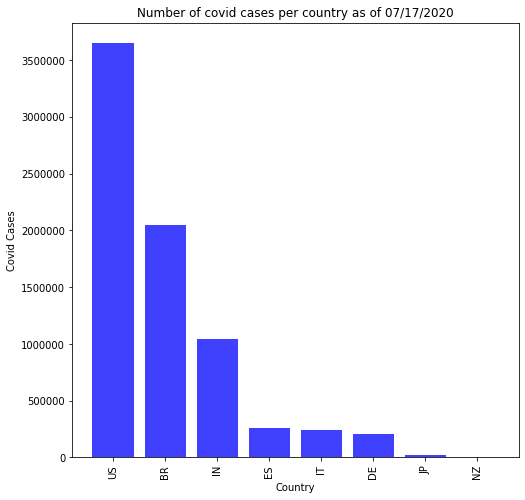

,Country,Cases
0,US,3647715
1,BR,2046328
2,IN,1039084
3,ES,260255
4,IT,243967
5,DE,202045
6,JP,24104
7,NZ,1550


<Figure size 432x288 with 0 Axes>

In [6]:
#----------------------------------------------------------
# Analyse Covid cases in Countries selected for 07/17/2020
#----------------------------------------------------------

Covid_data_07172020= Clean_Covid_2020.loc[(Clean_Covid_2020['Date'] =='2020-07-17'),:]
Group_Covid_07172020=Covid_data_07172020.groupby(['Country']).sum()
sorted_covid_07172020=Group_Covid_07172020.sort_values(by='Cases', ascending=False).reset_index()

# Generate a bar plot showing the number of covid cases for each country

# Set x axis and tick locations
x_axis = np.arange(len(Group_Covid_07172020))
tick_locations = [value for value in x_axis]

# Plot the bar with xtick labels 
plt.figure(figsize=(8,8))
plt.bar(x_axis, sorted_covid_07172020["Cases"], color='b', alpha=0.75, align="center")
plt.xticks(tick_locations, sorted_covid_07172020["Country"], rotation="vertical")

# Set textual properties
plt.ylabel("Covid Cases")
plt.xlabel("Country")
plt.title("Number of covid cases per country as of 07/17/2020")

#save figure 
plt.savefig("output_data/fig1.png")

# Show plot
plt.show()

# Resize plot to display labels
plt.tight_layout()


sorted_covid_07172020

In [7]:
#Define a function to create Linear Regression plots

def L_regress(x_value, y_value, x_lbl, y_lbl,title,linepos,fignum):
    
    # Perform a linear regression
    (slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_value, y_value)

    # Get regression values
    regress_value = x_value * slope + intercept
    
    # Print r square value
    print(f"The r-squared is: {rvalue**2}")
    
    #calculate correlation coefficient and print
    correlation = st.pearsonr(x_value,y_value)
    print(f"The correlation between covid cases and Air quality measurement value is {round(correlation[0],2)}")
    
    # Create Plot
    plt.scatter(x_value,y_value, marker="o", facecolors="blue", edgecolors="black", alpha=0.75)
    plt.plot(x_value,regress_value,"r-")
    plt.grid(b=None, which='major', axis='both')
    
    # Create line equation string
    line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))
    
    #Label plot and annotate the line equation
    plt.xlabel(x_lbl)
    plt.ylabel(y_lbl)
    plt.title(title)
    plt.annotate(line_eq,linepos,fontsize=15,color="red")

    #save figure 
    plt.savefig(f"output_data/fig{fignum}.png")

    # Show plot
    plt.show()
    
    

In [8]:
#Define a function to create line subplots for covid cases and air quality for 2020

def covid_aq_plot(x_value, y_value,y_covid_value,y_lbl,title,fignum):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Case Number', color=color)
    ax1.plot(x_value, y_covid_value, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    plt.title(title)
    ax2 = ax1.twinx()
    color2020 = 'tab:blue'
    #color2019= 'tab:green'
    ax2.set_ylabel(y_lbl, color=color2020)
    ax2.plot(x_value, y_value, color=color2020)
    #ax2.plot(x_NZ, y_NZ_aq_2019, color=color2019)
    ax2.tick_params(axis='y', labelcolor=color2020)
    fig.tight_layout()
    #save figure 
    plt.savefig(f"output_data/fig{fignum}.png")
    # Show plot
    plt.show()

In [9]:
# define a function to do statistical T-test and plot histogram
def Ttest_hist(AQ2019, AQ2020, lbl2019, lbl2020 ,title,fignum):
    
    #Plot Histogram
    plt.hist(AQ2019, 10, density=True, alpha=0.7, label=lbl2019)
    plt.hist(AQ2020, 10, density=True, alpha=0.7, label=lbl2020)
    plt.axvline(AQ2019.mean(), color='blue', linestyle='dashed', linewidth=1)
    plt.axvline(AQ2020.mean(), color='orange', linestyle='dashed', linewidth=1)
    plt.title(title)
    plt.xlabel('AQ')
    plt.ylabel('Pvalue')
    plt.legend()
    #save figure 
    plt.savefig(f"output_data/fig{fignum}.png")
    plt.show()

    

In [10]:
#Create a dataframe with just country infomation
Covid_data_country= Clean_Covid_2020[["Date", "Country", "Cases"]]
#Group by Date and country to get sum of cases for each day
group_covid_data= Covid_data_country.groupby(['Date','Country']).sum()
#group_covid_data

#Sort by date
sorted_covid_data=group_covid_data.sort_values(by='Date', ascending=False)
sorted_covid_data



Cases
Date       Country         
2020-07-21 US       3899211
           NZ          1555
           JP         26463
           IT        244752
           IN       1193078
...                     ...
2020-01-24 US             2
2020-01-23 JP             2
           US             1
2020-01-22 US             1
           JP             2

[1224 rows x 1 columns]

In [11]:

#----------------------------------------------------------------------------------
#Country level analysis for year 2020
#----------------------------------------------------------------------------------
#------------------------------------------
# Analyse the data for AQ parameter- PM2.5 
#------------------------------------------

aq2020_pm25_df = clean_aq2020_df.loc[clean_aq2020_df['Specie']=='pm25']

#Use median value for comparison 
aq2020_pm25_final_df=aq2020_pm25_df[['Date', 'Country','median']]

#Group by Date and Country
group_aq2020_pm25= aq2020_pm25_final_df.groupby(['Date','Country']).mean()

#Sort by Date
sorted_aq2020_pm25_df= group_aq2020_pm25.sort_values(by='Date', ascending=False)

#Reset index
sorted_aq2020_pm25_df.reset_index(inplace=True)
sorted_aq2020_pm25_df

#Combine covid data and AQ data by date and Country
combined_data_2020_pm25=pd.merge(sorted_covid_data,sorted_aq2020_pm25_df,how='inner', 
                            on =['Date','Country'] )

combined_data_2020_pm25




,Date,Country,Cases,median
0,2020-07-17,NZ,1550,27.666667
1,2020-07-17,JP,24104,25.387097
2,2020-07-17,IN,1039084,83.200000
3,2020-07-16,IT,243736,54.000000
4,2020-07-16,BR,2012151,20.600000
...,...,...,...,...
1190,2020-01-24,US,2,37.727273
1191,2020-01-23,JP,2,47.562500
1192,2020-01-23,US,1,39.981818
1193,2020-01-22,US,1,35.592593


In [12]:
#------------------------------------------
# Analyse the data for AQ parameter- CO 
#------------------------------------------

aq2020_co_df = clean_aq2020_df.loc[clean_aq2020_df['Specie']=='co']

#Use median value for comparison 
aq2020_co_final_df=aq2020_co_df[['Date', 'Country','median']]

#Group by Date and Country
group_aq2020_co= aq2020_co_final_df.groupby(['Date','Country']).mean()

#Sort by Date
sorted_aq2020_co_df= group_aq2020_co.sort_values(by='Date', ascending=False)

#Reset index
sorted_aq2020_co_df.reset_index(inplace=True)
sorted_aq2020_co_df

#Combine covid data and AQ data by date and Country
combined_data_2020_co=pd.merge(sorted_covid_data,sorted_aq2020_co_df,how='inner', 
                            on =['Date','Country'] )

combined_data_2020_co



,Date,Country,Cases,median
0,2020-07-17,NZ,1550,4.400000
1,2020-07-17,JP,24104,2.090476
2,2020-07-17,IN,1039084,4.900000
3,2020-07-16,IT,243736,3.700000
4,2020-07-16,BR,2012151,1.900000
...,...,...,...,...
1190,2020-01-24,US,2,4.271795
1191,2020-01-23,JP,2,5.346667
1192,2020-01-23,US,1,4.367500
1193,2020-01-22,US,1,3.565000


In [13]:
#------------------------------------------
# Analyse the data for AQ parameter- NO2 
#------------------------------------------

aq2020_no2_df = clean_aq2020_df.loc[clean_aq2020_df['Specie']=='no2']

#Use median value for comparison 
aq2020_no2_final_df=aq2020_no2_df[['Date', 'Country','median']]

#Group by Date and Country
group_aq2020_no2= aq2020_no2_final_df.groupby(['Date','Country']).mean()

#Sort by Date
sorted_aq2020_no2_df= group_aq2020_no2.sort_values(by='Date', ascending=False)

#Reset index
sorted_aq2020_no2_df.reset_index(inplace=True)
sorted_aq2020_no2_df

#Combine covid data and AQ data by date and Country
combined_data_2020_no2=pd.merge(sorted_covid_data,sorted_aq2020_no2_df,how='inner', 
                            on =['Date','Country'] )

combined_data_2020_no2

,Date,Country,Cases,median
0,2020-07-17,NZ,1550,3.800000
1,2020-07-17,JP,24104,4.506452
2,2020-07-17,IN,1039084,4.825000
3,2020-07-16,IT,243736,9.000000
4,2020-07-16,BR,2012151,6.166667
...,...,...,...,...
1190,2020-01-24,US,2,17.278947
1191,2020-01-23,JP,2,18.225000
1192,2020-01-23,US,1,18.950000
1193,2020-01-22,US,1,16.263158


In [14]:
#-----------------------------------------------------------------------------------
#Country level analysis for year 2019
#-----------------------------------------------------------------------------------

#------------------------------------------
# Analyse the data for AQ parameter- PM2.5 
#------------------------------------------

aq2019_pm25_df = clean_aq2019_df.loc[(clean_aq2019_df['Specie']=='pm25')&
                                      (clean_aq2019_df['Date']<='2019-07-17')&
                                      (clean_aq2019_df['Date']>='2019-01-01') ,:]

#Use median value for comparison 
aq2019_pm25_final_df=aq2019_pm25_df[['Date', 'Country','median']]

#Group by Date and Country
group_aq2019_pm25= aq2019_pm25_final_df.groupby(['Date','Country']).mean()

#Sort by Date
sorted_aq2019_pm25_df= group_aq2019_pm25.sort_values(by='Date', ascending=False)

#Reset index
sorted_aq2019_pm25_df.reset_index(inplace=True)
sorted_aq2019_pm25_df

#------------------------------------------
# Analyse the data for AQ parameter- CO 
#------------------------------------------

aq2019_co_df = clean_aq2019_df.loc[(clean_aq2019_df['Specie']=='co')&
                                      (clean_aq2019_df['Date']<='2019-07-17')&
                                      (clean_aq2019_df['Date']>='2019-01-01') ,:]

#Use median value for comparison 
aq2019_co_final_df=aq2019_co_df[['Date', 'Country','median']]

#Group by Date and Country
group_aq2019_co= aq2019_co_final_df.groupby(['Date','Country']).mean()

#Sort by Date
sorted_aq2019_co_df= group_aq2019_co.sort_values(by='Date', ascending=False)

#Reset index
sorted_aq2019_co_df.reset_index(inplace=True)
sorted_aq2019_co_df

#------------------------------------------
# Analyse the data for AQ parameter- NO2 
#------------------------------------------

aq2019_no2_df = clean_aq2019_df.loc[(clean_aq2019_df['Specie']=='no2')&
                                      (clean_aq2019_df['Date']<='2019-07-17')&
                                      (clean_aq2019_df['Date']>='2019-01-01') ,:]

#Use median value for comparison 
aq2019_no2_final_df=aq2019_no2_df[['Date', 'Country','median']]

#Group by Date and Country
group_aq2019_no2= aq2019_no2_final_df.groupby(['Date','Country']).mean()

#Sort by Date
sorted_aq2019_no2_df= group_aq2019_no2.sort_values(by='Date', ascending=False)

#Reset index
sorted_aq2019_no2_df.reset_index(inplace=True)
sorted_aq2019_no2_df



,Date,Country,median
0,2019-07-17,ZA,7.590000
1,2019-07-17,IR,44.928571
2,2019-07-17,IL,7.742857
3,2019-07-17,IE,3.600000
4,2019-07-17,HU,7.157143
...,...,...,...
10684,2019-01-01,MN,26.600000
10685,2019-01-01,MK,5.200000
10686,2019-01-01,KR,15.980000
10687,2019-01-01,JP,5.996875


The r-squared is: 0.05847627321132955
The correlation between covid cases and Air quality measurement value is 0.24


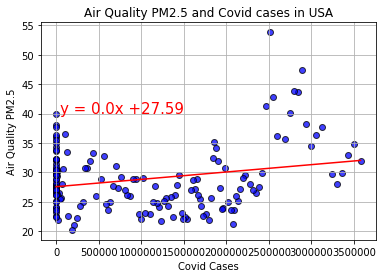

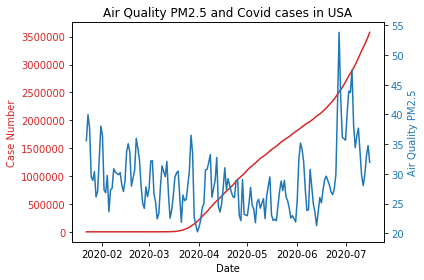

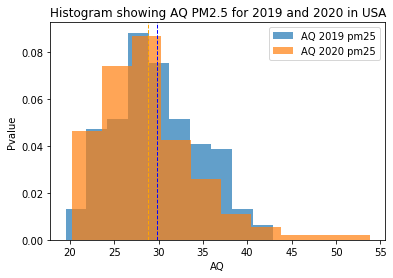

Ttest_indResult(statistic=1.711456961331204, pvalue=0.08795167716900874)

In [15]:
#-----------------------------
#Plot for US for PM2.5
#-----------------------------

US_data_2020=combined_data_2020_pm25.loc[combined_data_2020_pm25["Country"]=='US',:]
US_data_2020
x_value=US_data_2020['Cases']
y_value=US_data_2020['median']
x_lbl="Covid Cases"
y_lbl="Air Quality PM2.5"
title="Air Quality PM2.5 and Covid cases in USA"
linepos=(50000,40)
fignum=2

#Calling Linear regress function
L_regress(x_value, y_value,x_lbl,y_lbl,title,linepos,fignum)


#set x and y axis values for line plot
x_date_value=US_data_2020["Date"]
y_covid_value=US_data_2020["Cases"]
y_aq_value=US_data_2020["median"]
fignum1=3

#Calling Line plot function
covid_aq_plot(x_date_value, y_aq_value,y_covid_value,y_lbl,title,fignum1)

#---------------------------------------------------
# T-test AQ data for 2019 and 2020 get the pvalue
#---------------------------------------------------
#2019 data for USA
US_data_2019=sorted_aq2019_pm25_df.loc[sorted_aq2019_pm25_df["Country"]=='US',:]

#set variable value for 2019
AQ2019=US_data_2019['median']
AQ2020=US_data_2020['median']
lbl2019="AQ 2019 pm25"
lbl2020="AQ 2020 pm25"
title="Histogram showing AQ PM2.5 for 2019 and 2020 in USA"
fignum=4
Ttest_hist(AQ2019, AQ2020, lbl2019, lbl2020 ,title,fignum)
st.ttest_ind(AQ2019, AQ2020, equal_var=False)

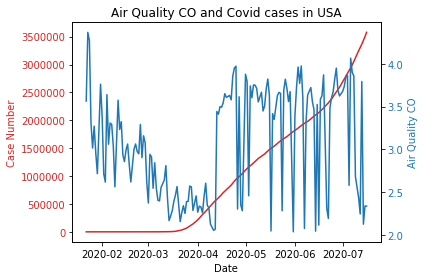

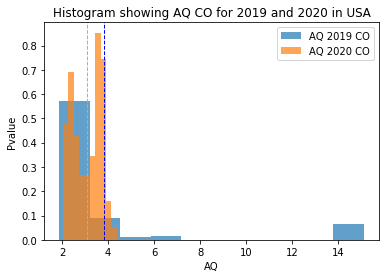

Ttest_indResult(statistic=2.985429403909731, pvalue=0.0031632734132810226)

In [16]:
#-----------------------------
#Plot for US for CO
#-----------------------------

US_data_2020=combined_data_2020_co.loc[combined_data_2020_co["Country"]=='US',:]
US_data_2020
x_value=US_data_2020['Cases']
y_value=US_data_2020['median']
x_lbl="Covid Cases"
y_lbl="Air Quality CO"
title="Air Quality CO and Covid cases in USA"
linepos=(50000,40)
fignum=26

#Calling Linear regress function
#L_regress(x_value, y_value,x_lbl,y_lbl,title,linepos,fignum)

#set x and y axis values for line plot
x_date_value=US_data_2020["Date"]
y_covid_value=US_data_2020["Cases"]
y_aq_value=US_data_2020["median"]
fignum1=27

#Calling Line plot function
covid_aq_plot(x_date_value, y_aq_value,y_covid_value,y_lbl,title,fignum1)

#---------------------------------------------------
# T-test AQ data for 2019 and 2020 get the pvalue
#---------------------------------------------------
#2019 data for USA
US_data_2019=sorted_aq2019_co_df.loc[sorted_aq2019_co_df["Country"]=='US',:]

#set variable value for 2019
AQ2019=US_data_2019['median']
AQ2020=US_data_2020['median']
lbl2019="AQ 2019 CO"
lbl2020="AQ 2020 CO"
title="Histogram showing AQ CO for 2019 and 2020 in USA"
fignum=28
Ttest_hist(AQ2019, AQ2020, lbl2019, lbl2020 ,title,fignum)
st.ttest_ind(AQ2019, AQ2020, equal_var=False)






The r-squared is: 0.3337483725830523
The correlation between covid cases and Air quality measurement value is -0.58


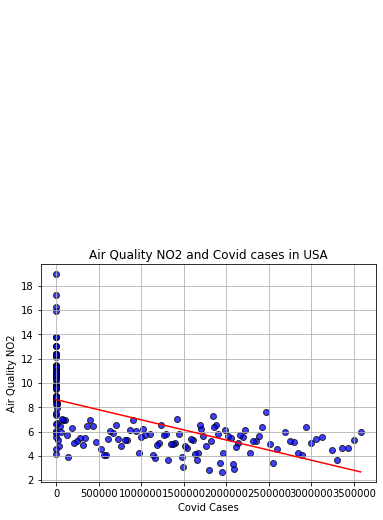

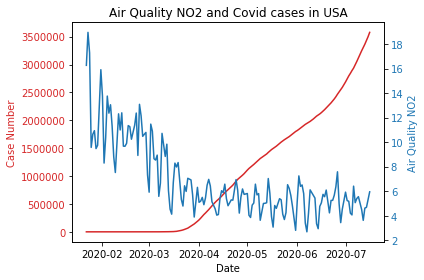

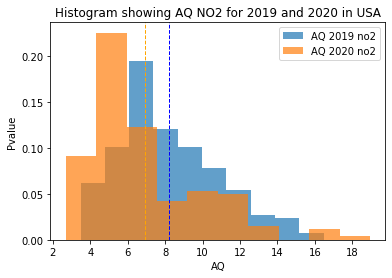

Ttest_indResult(statistic=4.081770732298556, pvalue=5.6396013127592594e-05)

In [17]:
#-----------------------------
#Plot for US for NO2
#-----------------------------

US_data_2020=combined_data_2020_no2.loc[combined_data_2020_no2["Country"]=='US',:]
US_data_2020
x_value=US_data_2020['Cases']
y_value=US_data_2020['median']
x_lbl="Covid Cases"
y_lbl="Air Quality NO2"
title="Air Quality NO2 and Covid cases in USA"
linepos=(50000,40)
fignum=29

#Calling Linear regress function
L_regress(x_value, y_value,x_lbl,y_lbl,title,linepos,fignum)


#set x and y axis values for line plot
x_date_value=US_data_2020["Date"]
y_covid_value=US_data_2020["Cases"]
y_aq_value=US_data_2020["median"]
fignum1=30

#Calling Line plot function
covid_aq_plot(x_date_value, y_aq_value,y_covid_value,y_lbl,title,fignum1)

#---------------------------------------------------
# T-test AQ data for 2019 and 2020 get the pvalue
#---------------------------------------------------
#2019 data for USA
US_data_2019=sorted_aq2019_no2_df.loc[sorted_aq2019_no2_df["Country"]=='US',:]

#set variable value for 2019
AQ2019=US_data_2019['median']
AQ2020=US_data_2020['median']
lbl2019="AQ 2019 no2"
lbl2020="AQ 2020 no2"
title="Histogram showing AQ NO2 for 2019 and 2020 in USA"
fignum=31
Ttest_hist(AQ2019, AQ2020, lbl2019, lbl2020 ,title,fignum)
st.ttest_ind(AQ2019, AQ2020, equal_var=False)

The r-squared is: 0.0004891638936896562
The correlation between covid cases and Air quality measurement value is -0.02


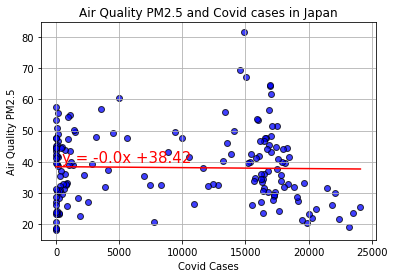

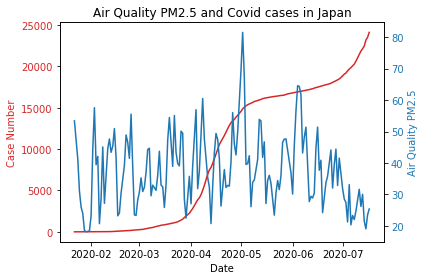

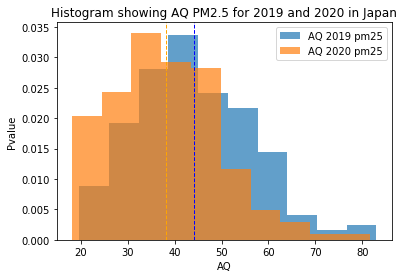

Ttest_indResult(statistic=4.762520590221334, pvalue=2.801378442025747e-06)

In [18]:
#-----------------------------
#Plot for Japan for PM2.5
#-----------------------------

JP_data_2020=combined_data_2020_pm25.loc[combined_data_2020_pm25["Country"]=='JP',:]
JP_data_2020
x_value=JP_data_2020['Cases']
y_value=JP_data_2020['median']
x_lbl="Covid Cases"
y_lbl="Air Quality PM2.5"
title="Air Quality PM2.5 and Covid cases in Japan"
linepos=(500,40)
fignum=5

#Calling Linear regress function
L_regress(x_value, y_value,x_lbl,y_lbl,title,linepos,fignum)


#set x and y axis values for line plot
x_date_value=JP_data_2020["Date"]
y_covid_value=JP_data_2020["Cases"]
y_aq_value=JP_data_2020["median"]
fignum1=6

#Calling Line plot function
covid_aq_plot(x_date_value, y_aq_value,y_covid_value,y_lbl,title,fignum1)

#---------------------------------------------------
# T-test AQ data for 2019 and 2020 get the pvalue
#---------------------------------------------------
#2019 data for Japan
JP_data_2019=sorted_aq2019_pm25_df.loc[sorted_aq2019_pm25_df["Country"]=='JP',:]

#set variable value for 2019
AQ2019=JP_data_2019['median']
AQ2020=JP_data_2020['median']
lbl2019="AQ 2019 pm25"
lbl2020="AQ 2020 pm25"
title="Histogram showing AQ PM2.5 for 2019 and 2020 in Japan"
fignum=7
Ttest_hist(AQ2019, AQ2020, lbl2019, lbl2020 ,title,fignum)
st.ttest_ind(AQ2019, AQ2020, equal_var=False)

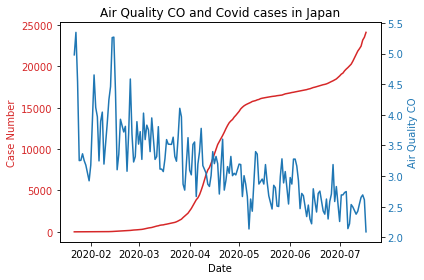

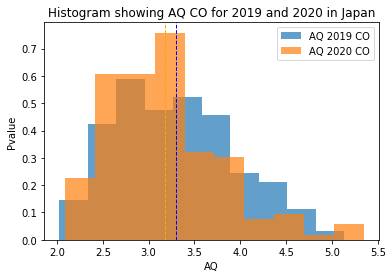

Ttest_indResult(statistic=1.8672275691891902, pvalue=0.06270463937454818)

In [19]:
#-----------------------------
#Plot for Japan for CO
#-----------------------------

JP_data_2020=combined_data_2020_co.loc[combined_data_2020_co["Country"]=='JP',:]
JP_data_2020
x_value=JP_data_2020['Cases']
y_value=JP_data_2020['median']
x_lbl="Covid Cases"
y_lbl="Air Quality CO"
title="Air Quality CO and Covid cases in Japan"
linepos=(500,40)
fignum=32

#Calling Linear regress function
#L_regress(x_value, y_value,x_lbl,y_lbl,title,linepos,fignum)


#set x and y axis values for line plot
x_date_value=JP_data_2020["Date"]
y_covid_value=JP_data_2020["Cases"]
y_aq_value=JP_data_2020["median"]
fignum1=33

#Calling Line plot function
covid_aq_plot(x_date_value, y_aq_value,y_covid_value,y_lbl,title,fignum1)

#---------------------------------------------------
# T-test AQ data for 2019 and 2020 get the pvalue
#---------------------------------------------------
#2019 data for Japan
JP_data_2019=sorted_aq2019_co_df.loc[sorted_aq2019_co_df["Country"]=='JP',:]

#set variable value for 2019
AQ2019=JP_data_2019['median']
AQ2020=JP_data_2020['median']
lbl2019="AQ 2019 CO"
lbl2020="AQ 2020 CO"
title="Histogram showing AQ CO for 2019 and 2020 in Japan"
fignum=34
Ttest_hist(AQ2019, AQ2020, lbl2019, lbl2020 ,title,fignum)
st.ttest_ind(AQ2019, AQ2020, equal_var=False)

The r-squared is: 0.2953113769218607
The correlation between covid cases and Air quality measurement value is -0.54


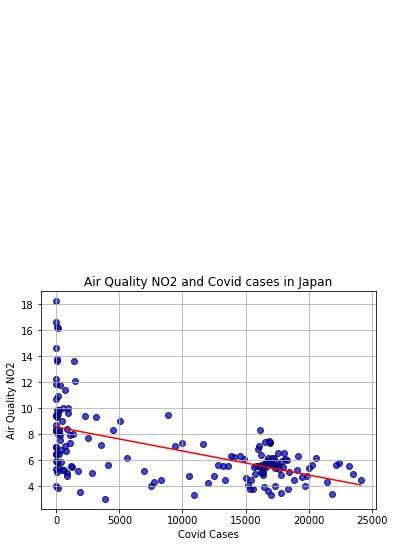

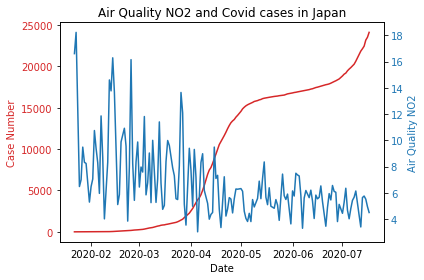

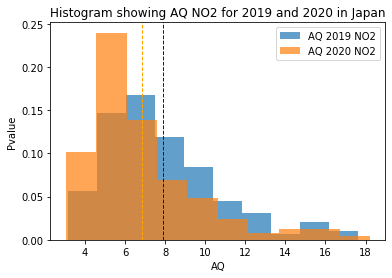

Ttest_indResult(statistic=3.6165664312481582, pvalue=0.00034267665083899553)

In [20]:
#-----------------------------
#Plot for Japan for NO2
#-----------------------------

JP_data_2020=combined_data_2020_no2.loc[combined_data_2020_no2["Country"]=='JP',:]
JP_data_2020
x_value=JP_data_2020['Cases']
y_value=JP_data_2020['median']
x_lbl="Covid Cases"
y_lbl="Air Quality NO2"
title="Air Quality NO2 and Covid cases in Japan"
linepos=(500,40)
fignum=35

#Calling Linear regress function
L_regress(x_value, y_value,x_lbl,y_lbl,title,linepos,fignum)


#set x and y axis values for line plot
x_date_value=JP_data_2020["Date"]
y_covid_value=JP_data_2020["Cases"]
y_aq_value=JP_data_2020["median"]
fignum1=36

#Calling Line plot function
covid_aq_plot(x_date_value, y_aq_value,y_covid_value,y_lbl,title,fignum1)

#---------------------------------------------------
# T-test AQ data for 2019 and 2020 get the pvalue
#---------------------------------------------------
#2019 data for Japan
JP_data_2019=sorted_aq2019_no2_df.loc[sorted_aq2019_no2_df["Country"]=='JP',:]

#set variable value for 2019
AQ2019=JP_data_2019['median']
AQ2020=JP_data_2020['median']
lbl2019="AQ 2019 NO2"
lbl2020="AQ 2020 NO2"
title="Histogram showing AQ NO2 for 2019 and 2020 in Japan"
fignum=37
Ttest_hist(AQ2019, AQ2020, lbl2019, lbl2020 ,title,fignum)
st.ttest_ind(AQ2019, AQ2020, equal_var=False)

The r-squared is: 0.44128335231973476
The correlation between covid cases and Air quality measurement value is -0.66


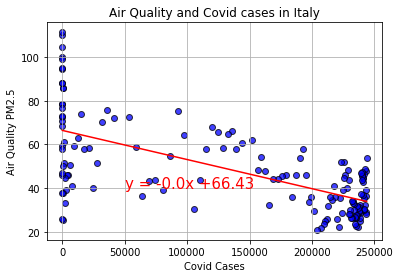

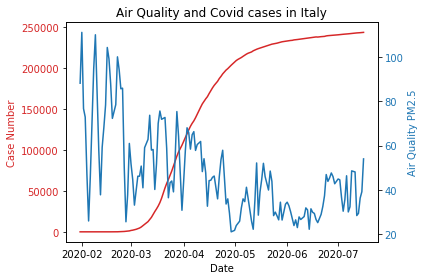

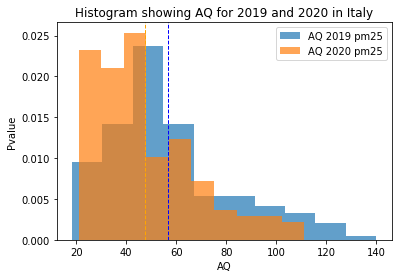

Ttest_indResult(statistic=3.8057587000084347, pvalue=0.00016694337628164732)

In [21]:
#-----------------------------
#Plot for Italy for PM2.5
#-----------------------------

IT_data_2020=combined_data_2020_pm25.loc[combined_data_2020_pm25["Country"]=='IT',:]
IT_data_2020
x_value=IT_data_2020['Cases']
y_value=IT_data_2020['median']
x_lbl="Covid Cases"
y_lbl="Air Quality PM2.5"
title="Air Quality and Covid cases in Italy"
linepos=(50000,40)
fignum=8

#Calling Linear regress function
L_regress(x_value, y_value,x_lbl,y_lbl,title,linepos,fignum)


#set x and y axis values for line plot
x_date_value=IT_data_2020["Date"]
y_covid_value=IT_data_2020["Cases"]
y_aq_value=IT_data_2020["median"]
fignum1=9

#Calling Line plot function
covid_aq_plot(x_date_value, y_aq_value,y_covid_value,y_lbl,title,fignum1)

#---------------------------------------------------
# T-test AQ data for 2019 and 2020 get the pvalue
#---------------------------------------------------
#2019 data for Italy
IT_data_2019=sorted_aq2019_pm25_df.loc[sorted_aq2019_pm25_df["Country"]=='IT',:]

#set variable value for 2019
AQ2019=IT_data_2019['median']
AQ2020=IT_data_2020['median']
lbl2019="AQ 2019 pm25"
lbl2020="AQ 2020 pm25"
title="Histogram showing AQ for 2019 and 2020 in Italy"
fignum=10
Ttest_hist(AQ2019, AQ2020, lbl2019, lbl2020 ,title,fignum)
st.ttest_ind(AQ2019, AQ2020, equal_var=False)

The r-squared is: 0.1096837016822145
The correlation between covid cases and Air quality measurement value is 0.33


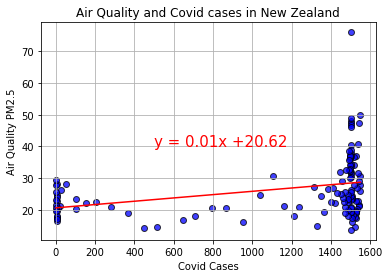

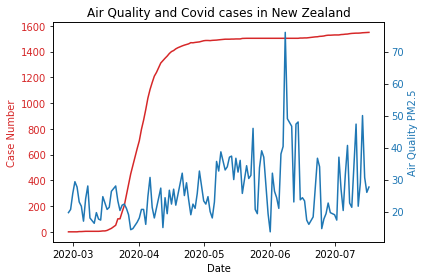

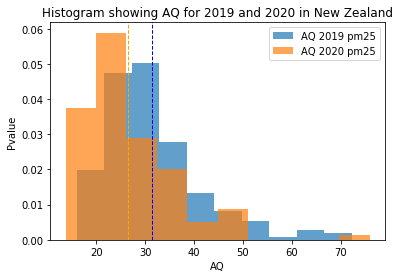

Ttest_indResult(statistic=4.4787399609863, pvalue=1.0956604486471291e-05)

In [22]:
#------------------------------
#Plot for New Zealand for PM2.5
#------------------------------


NZ_data_2020=combined_data_2020_pm25.loc[combined_data_2020_pm25["Country"]=='NZ',:]
NZ_data_2020
x_value=NZ_data_2020['Cases']
y_value=NZ_data_2020['median']
x_lbl="Covid Cases"
y_lbl="Air Quality PM2.5"
title="Air Quality and Covid cases in New Zealand"
linepos=(500,40)
fignum=11


#Calling Linear regress function
L_regress(x_value, y_value,x_lbl,y_lbl,title,linepos,fignum)

#set x and y axis values for line plot
x_date_value=NZ_data_2020["Date"]
y_covid_value=NZ_data_2020["Cases"]
y_aq_value=NZ_data_2020["median"]
fignum1=12

#Calling Line plot function
covid_aq_plot(x_date_value, y_aq_value,y_covid_value,y_lbl,title,fignum1)

#---------------------------------------------------
# T-test AQ data for 2019 and 2020 get the pvalue
#---------------------------------------------------
#2019 data for New Zealand
NZ_data_2019=sorted_aq2019_pm25_df.loc[sorted_aq2019_pm25_df["Country"]=='NZ',:]

#set variable value for 2019
AQ2019=NZ_data_2019['median']
AQ2020=NZ_data_2020['median']
lbl2019="AQ 2019 pm25"
lbl2020="AQ 2020 pm25"
title="Histogram showing AQ for 2019 and 2020 in New Zealand"
fignum=13
Ttest_hist(AQ2019, AQ2020, lbl2019, lbl2020 ,title,fignum)
st.ttest_ind(AQ2019, AQ2020, equal_var=False)


The r-squared is: 0.004496567279710659
The correlation between covid cases and Air quality measurement value is -0.07


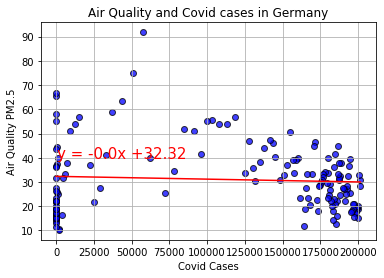

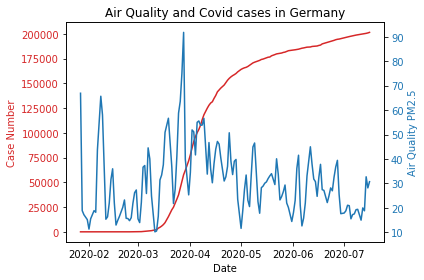

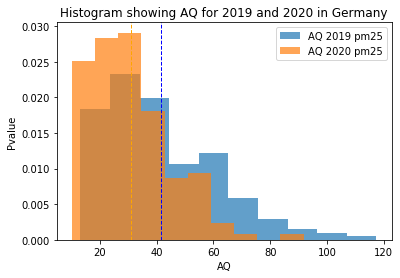

Ttest_indResult(statistic=5.701307751067691, pvalue=2.5371712011765325e-08)

In [23]:
#-----------------
#Plot for Germany
#-----------------

DE_data_2020=combined_data_2020_pm25.loc[combined_data_2020_pm25["Country"]=='DE',:]
x_value=DE_data_2020['Cases']
y_value=DE_data_2020['median']
x_lbl="Covid Cases"
y_lbl="Air Quality PM2.5"
title="Air Quality and Covid cases in Germany"
linepos=(500,40)
fignum=14

#Calling Linear regress function
L_regress(x_value, y_value,x_lbl,y_lbl,title,linepos,fignum)

#set x and y axis values for line plot
x_date_value=DE_data_2020["Date"]
y_covid_value=DE_data_2020["Cases"]
y_aq_value=DE_data_2020["median"]
fignum1=15

#Calling Line plot function
covid_aq_plot(x_date_value, y_aq_value,y_covid_value,y_lbl,title,fignum1)

#---------------------------------------------------
# T-test AQ data for 2019 and 2020 get the pvalue
#---------------------------------------------------
#2019 data for Germany
DE_data_2019=sorted_aq2019_pm25_df.loc[sorted_aq2019_pm25_df["Country"]=='DE',:]

#set variable value for 2019
AQ2019=DE_data_2019['median']
AQ2020=DE_data_2020['median']
lbl2019="AQ 2019 pm25"
lbl2020="AQ 2020 pm25"
title="Histogram showing AQ for 2019 and 2020 in Germany"
fignum=16
Ttest_hist(AQ2019, AQ2020, lbl2019, lbl2020 ,title,fignum)
st.ttest_ind(AQ2019, AQ2020, equal_var=False)


The r-squared is: 0.1618250497492136
The correlation between covid cases and Air quality measurement value is -0.4


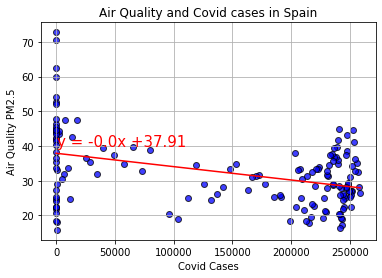

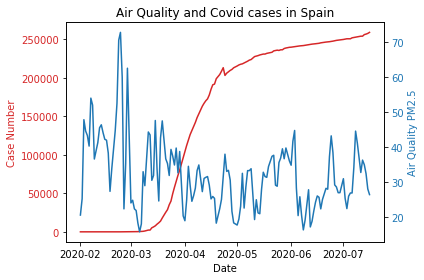

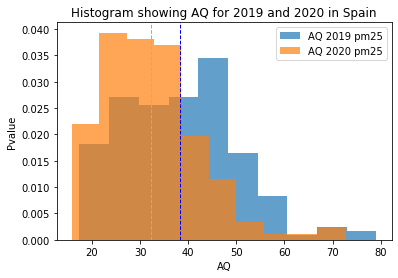

Ttest_indResult(statistic=5.094008871053512, pvalue=5.788623614535006e-07)

In [24]:
#----------------
#Plot for Spain
#----------------

ES_data_2020=combined_data_2020_pm25.loc[combined_data_2020_pm25["Country"]=='ES',:]
x_value=ES_data_2020['Cases']
y_value=ES_data_2020['median']
x_lbl="Covid Cases"
y_lbl="Air Quality PM2.5"
title="Air Quality and Covid cases in Spain"
linepos=(500,40)
fignum=17

#Calling Linear regress function
L_regress(x_value, y_value,x_lbl,y_lbl,title,linepos,fignum)

#set x and y axis values for line plot
x_date_value=ES_data_2020["Date"]
y_covid_value=ES_data_2020["Cases"]
y_aq_value=ES_data_2020["median"]
fignum1=18

#Calling Line plot function
covid_aq_plot(x_date_value, y_aq_value,y_covid_value,y_lbl,title,fignum1)

#---------------------------------------------------
# T-test AQ data for 2019 and 2020 get the pvalue
#---------------------------------------------------
#2019 data for Spain
ES_data_2019=sorted_aq2019_pm25_df.loc[sorted_aq2019_pm25_df["Country"]=='ES',:]

#set variable value for 2019
AQ2019=ES_data_2019['median']
AQ2020=ES_data_2020['median']
lbl2019="AQ 2019 pm25"
lbl2020="AQ 2020 pm25"
title="Histogram showing AQ for 2019 and 2020 in Spain"
fignum=19
Ttest_hist(AQ2019, AQ2020, lbl2019, lbl2020 ,title,fignum)
st.ttest_ind(AQ2019, AQ2020, equal_var=False)



The r-squared is: 0.048660295396092734
The correlation between covid cases and Air quality measurement value is 0.22


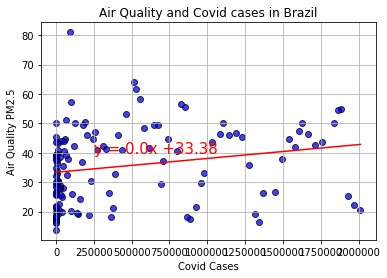

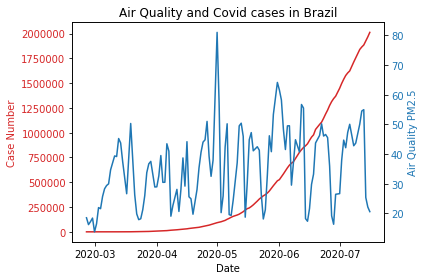

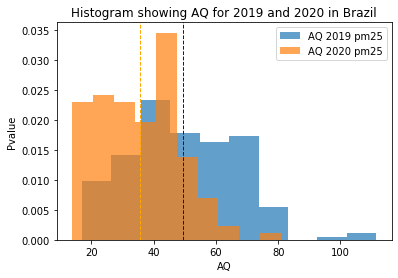

Ttest_indResult(statistic=8.205936310272454, pvalue=5.699563038300534e-15)

In [25]:
#----------------
#Plot for Brazil
#----------------

BR_data_2020=combined_data_2020_pm25.loc[combined_data_2020_pm25["Country"]=='BR',:]
x_value=BR_data_2020['Cases']
y_value=BR_data_2020['median']
x_lbl="Covid Cases"
y_lbl="Air Quality PM2.5"
title="Air Quality and Covid cases in Brazil"
linepos=(250000,40)
fignum=20

#Calling Linear regress function
L_regress(x_value, y_value,x_lbl,y_lbl,title,linepos,fignum)

#set x and y axis values for line plot
x_date_value=BR_data_2020["Date"]
y_covid_value=BR_data_2020["Cases"]
y_aq_value=BR_data_2020["median"]
fignum1=21

#Calling Line plot function
covid_aq_plot(x_date_value, y_aq_value,y_covid_value,y_lbl,title,fignum1)

#---------------------------------------------------
# T-test AQ data for 2019 and 2020 get the pvalue
#---------------------------------------------------
#2019 data for Brazil
BR_data_2019=sorted_aq2019_pm25_df.loc[sorted_aq2019_pm25_df["Country"]=='BR',:]

#set variable value for 2019
AQ2019=BR_data_2019['median']
AQ2020=BR_data_2020['median']
lbl2019="AQ 2019 pm25"
lbl2020="AQ 2020 pm25"
title="Histogram showing AQ for 2019 and 2020 in Brazil"
fignum=22
Ttest_hist(AQ2019, AQ2020, lbl2019, lbl2020 ,title,fignum)
st.ttest_ind(AQ2019, AQ2020, equal_var=False)


The r-squared is: 0.3031638106365896
The correlation between covid cases and Air quality measurement value is -0.55


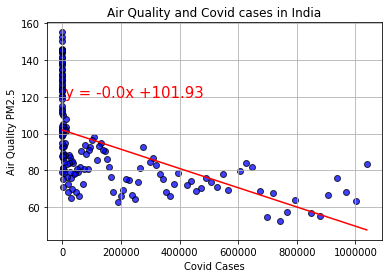

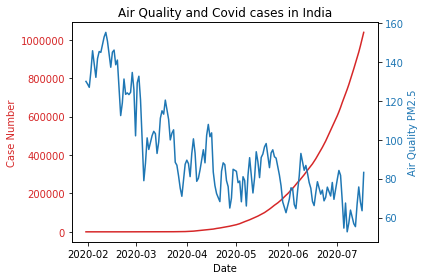

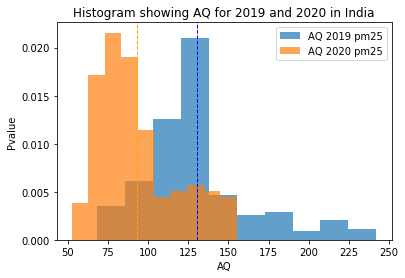

Ttest_indResult(statistic=12.00970416900682, pvalue=4.878112529229626e-28)

In [26]:
#----------------
#Plot for India
#----------------

IN_data_2020=combined_data_2020_pm25.loc[combined_data_2020_pm25["Country"]=='IN',:]

#set x and y axis values for regression plot
x_value=IN_data_2020['Cases']
y_value=IN_data_2020['median']
x_lbl="Covid Cases"
y_lbl="Air Quality PM2.5"
title="Air Quality and Covid cases in India"
linepos=(10000,120)
fignum=23

#Calling Linear regress function
L_regress(x_value, y_value,x_lbl,y_lbl,title,linepos,fignum)

#set x and y axis values for line plot
x_date_value=IN_data_2020["Date"]
y_covid_value=IN_data_2020["Cases"]
y_aq_value=IN_data_2020["median"]
fignum1=24

#Calling Line plot function
covid_aq_plot(x_date_value, y_aq_value,y_covid_value,y_lbl,title,fignum1)

#---------------------------------------------------
# T-test AQ data for 2019 and 2020 get the pvalue
#---------------------------------------------------
#2019 data for India
IN_data_2019=sorted_aq2019_pm25_df.loc[sorted_aq2019_pm25_df["Country"]=='IN',:]

#set variable value for 2019
AQ2019=IN_data_2019['median']
AQ2020=IN_data_2020['median']
lbl2019="AQ 2019 pm25"
lbl2020="AQ 2020 pm25"
title="Histogram showing AQ for 2019 and 2020 in India"
fignum=25
Ttest_hist(AQ2019, AQ2020, lbl2019, lbl2020 ,title,fignum)
st.ttest_ind(AQ2019, AQ2020, equal_var=False)
